In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

#import warnings
#warnings.filterwarnings("ignore")
#warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [21]:
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os

In [27]:
import tensorflow as tf

from tensorflow import keras
from keras import layers

tf.config.list_physical_devices("GPU")

[]

In [13]:
import zipfile

# Unzip the file
zip_ref = zipfile.ZipFile("Lung Cancer Detection\lung_colon_image_set.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [15]:
my_data_dir = "lung_colon_image_set"

In [16]:
os.listdir(my_data_dir)

['colon_image_sets', 'lung_image_sets']

In [17]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

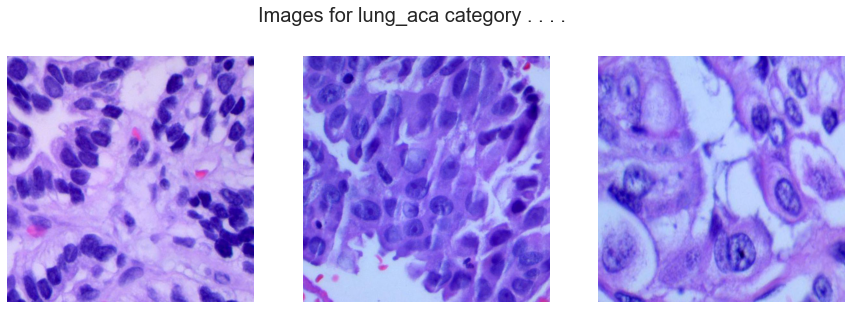

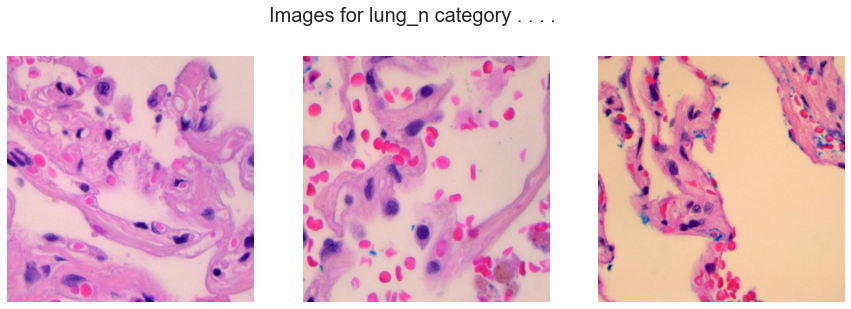

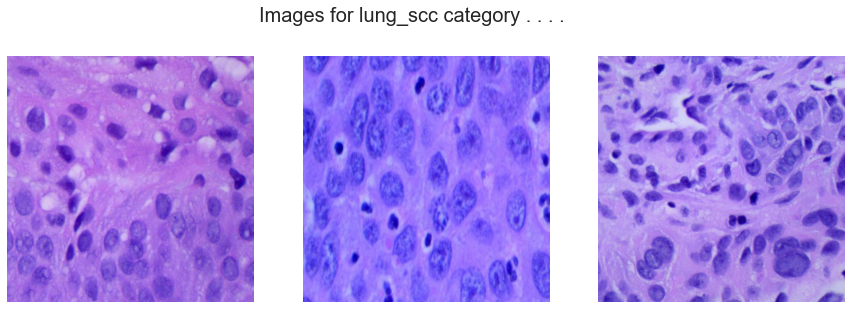

In [20]:
from PIL import Image

path = 'lung_colon_image_set/lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [37]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [24]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [25]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [28]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [33]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [34]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [38]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 559s 3s/step - loss: 0.1046 - accuracy: 0.9616 - val_loss: 3.7974 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 558s 3s/step - loss: 0.0903 - accuracy: 0.9660 - val_loss: 2.8693 - val_accuracy: 0.5770 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 4042s 22s/step - loss: 0.0776 - accuracy: 0.9700 - val_loss: 2.4832 - val_accuracy: 0.6887 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 642s 3s/step - loss: 0.0713 - accuracy: 0.9725 - val_loss: 2.9403 - val_accuracy: 0.5653 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 644s 3s/step - loss: 0.0454 - accuracy: 0.9843 - val_loss: 0.6192 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 644s 3s/step - loss: 0.0312 - accuracy: 0.9899 - val_loss: 5.2765 - val_accuracy: 0.5793 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - ETA: 0s 

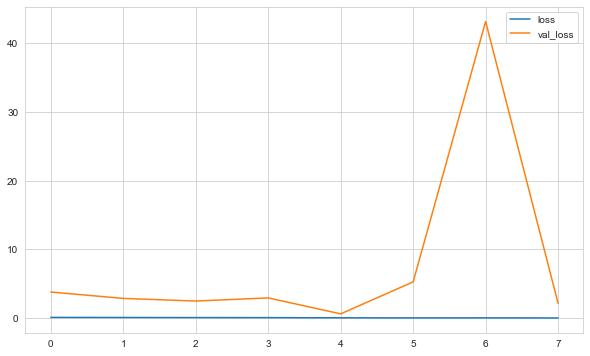

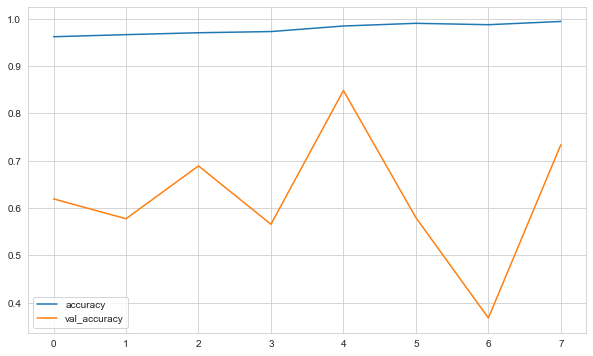

In [39]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [40]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 25s 262ms/step


In [41]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[859, 100,  28],
       [  1, 976,   0],
       [321,   6, 709]], dtype=int64)

In [42]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.73      0.87      0.79       987
      lung_n       0.90      1.00      0.95       977
    lung_scc       0.96      0.68      0.80      1036

    accuracy                           0.85      3000
   macro avg       0.86      0.85      0.85      3000
weighted avg       0.87      0.85      0.85      3000

